### NOAA Global Historical Climatology Network Daily (GHCN-D)

the noaa data was downloaded from an S3 bucket descried here

https://registry.opendata.aws/noaa-ghcn/


#### The files and subdirs in noaa

### Main Data Directory
* **98G	csv.gz**

### Documentation
* 36K	ghcn-daily-by_year-format.rtf
* 6.5K	ghcnd-countries.txt
* 32M	ghcnd-inventory.txt
* 6.5K	ghcnd-states.txt
* 9.9M	ghcnd-stations.txt
* 6.5K	ghcnd-version.txt
* 36K	index.html
* 4.1M	mingle-list.txt
* 6.5K	readme-by_year.txt
* 30K	readme.txt
* 6.5K	status-by_year.txt
* 41K	status.txt

### Logs
* 37M	download.log


In [1]:
import pandas as pd

In [2]:
!head -4 file.sizes

total 102208244
-rw-r--r-- 1 yfreund root      532654 Apr  5 15:59 1750.csv
-rw-r--r-- 1 yfreund root       25276 Apr  5 16:00 1763.csv
-rw-r--r-- 1 yfreund root       25283 Apr  5 16:00 1764.csv


In [3]:
!tail -4 file.sizes

-rw-r--r-- 1 yfreund root  1220722777 Apr  5 15:57 2020.csv
-rw-r--r-- 1 yfreund root  1207975107 Apr  5 15:58 2021.csv
-rw-r--r-- 1 yfreund root   276207286 Apr  5 15:59 2022.csv
-rw-r----- 1 yfreund users          0 Apr  9 16:22 file.sizes


In [4]:
i=0
D={}
with open('file.sizes','r') as S:
    S.readline(); S.readline()
    for line in S.readlines():
        if 'file' in line:
            continue
        #print(line[:-1])
        L=line.split()
        size=int(L[4])
        year=int(L[-1][:-4])
        #print(year,size)
        D[year]=size


In [5]:
years=[]
sizes=[]
for year in sorted(D.keys()):
    years.append(year)
    sizes.append(D[year])

In [6]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


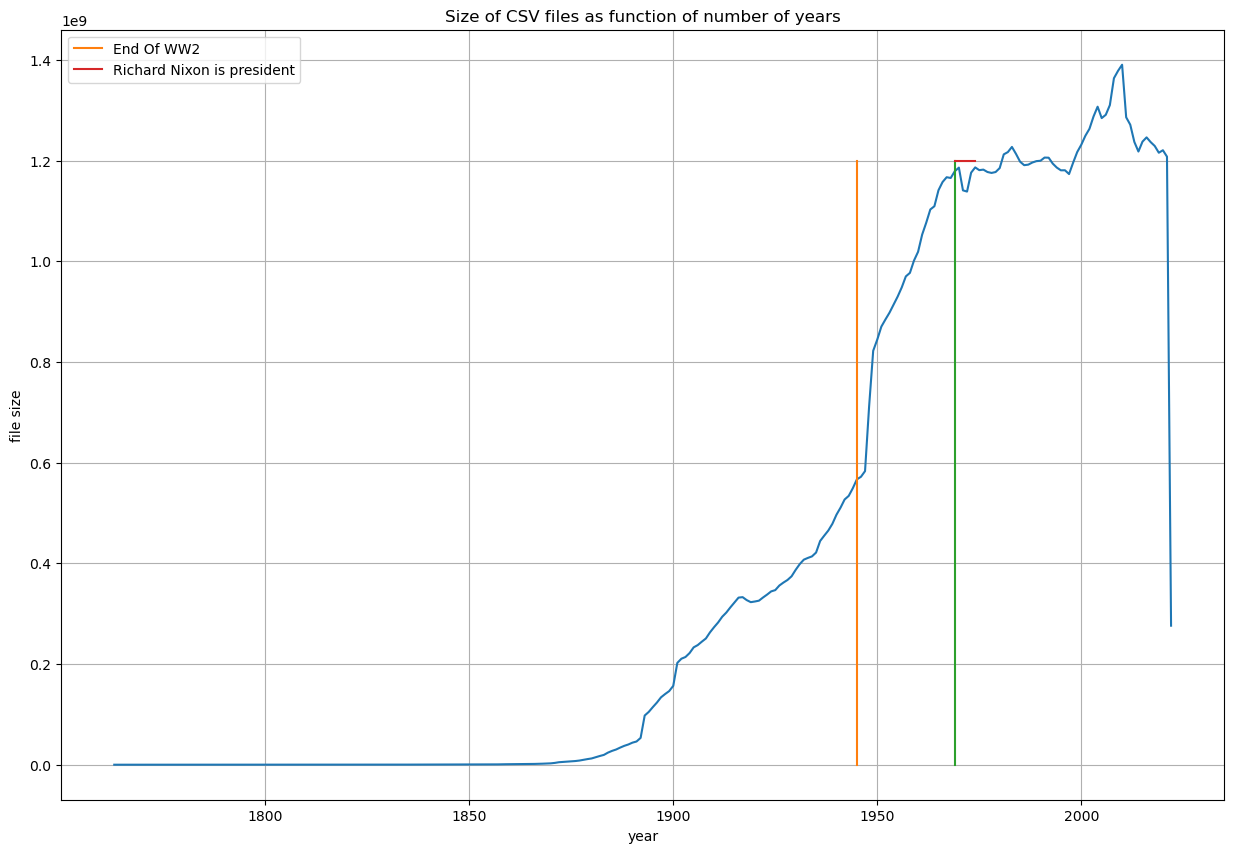

In [7]:
figure(figsize=[15,10])
plot(years,sizes)
plot([1945,1945],[0,1.2e9],label='End Of WW2')
plot([1969,1969],[0,1.2e9]) 
plot([1969,1974],[1.2e9,1.2e9],label='Richard Nixon is president')
title('Size of CSV files as function of number of years')
xlabel('year')
ylabel('file size')
legend()
grid()

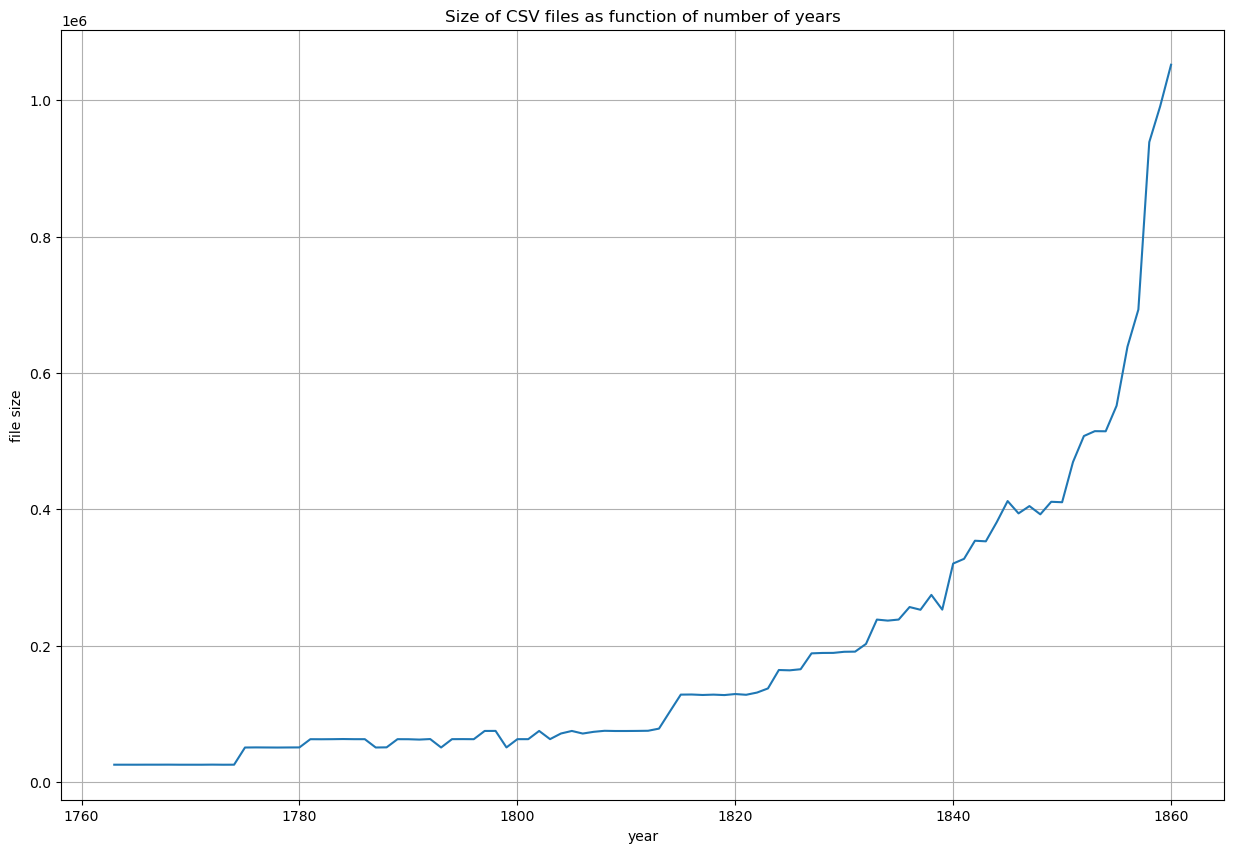

In [8]:
figure(figsize=[15,10])
plot(years[:98],sizes[:98])
title('Size of CSV files as function of number of years')
xlabel('year')
ylabel('file size')
grid()

### Data format

Data is in csv (comma separated values)

Typical data:  
`
ITE00100554,17630101,TMAX,-36,,,E,
ITE00100554,17630101,TMIN,-50,,,E,
ITE00100554,17630102,TMAX,-26,,,E,
ITE00100554,17630102,TMIN,-40,,,E,
ITE00100554,17630103,TMAX,-9,,,E,
ITE00100554,17630103,TMIN,-29,,,E,
ITE00100554,17630104,TMAX,-4,,,E,
ITE00100554,17630104,TMIN,-24,,,E,
ITE00100554,17630105,TMAX,21,,,E,
ITE00100554,17630105,TMIN,1,,,E,`

### Main Fields
`ITE00100554,17630101,TMAX,-36,,,E,`

* `ITE00100554`  name of meteorological station (IT = Italy)
* `17630101`  Date: January 1, 1763
* `TMAX` Type of measurement: Maximal temperature during day
* `-36` The reading (-3.6 degrees centigrade)
* `,,,E,` Other parametersout of which only the next to last is defined 

In [9]:
import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType,BinaryType

from pyspark import SparkContext

In [10]:
### Spark setup 
sc = SparkContext(pyFiles=[os.getcwd()+'/lib/numpy_pack.py'])
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [11]:
!ls lib

binary_search.py      leaflet.py	       sparkConfig.py
computeStatistics.py  lib		       spark_PCA_HW.py
decomposer.py	      MultiPlot.py	       spark_PCA.py
environ.yaml	      numpy_pack.py	       startup.py
getFiles.py	      old		       YearPlotter.py
import_modules.py     Reconstruction_plots.py
__init__.py	      row_parser.py


In [18]:
filename='../Data/Weather/2020.csv'
print(filename) 
T=sc.textFile(filename)  

../Data/Weather/2020.csv


In [19]:
T.count()

36869650

In [26]:
header = T.first() #extract header
T = T.filter(lambda row: row != header)

In [27]:
def ymd2dy(year,month,day):
    """ Translate nomerical year,month,day into day of year """
    today = datetime.date(year,month,day)
    jan1=datetime.date(year,1,1) 
    diff=today-jan1
    return diff.days+1

def parse(line):
    _list=line.split(',')
    station,date,measurement,value=_list[:4]
    year=int(date[:4])
    month=int(date[4:6])
    day=int(date[6:])
    dy = ymd2dy(year,month,day)
    value=int(value)
    return station,year,dy,measurement,value

In [28]:
T.take(1)

['AE000041196,20200101,TMIN,168,,,S,']

In [29]:
%%time
P=T.map(parse)

CPU times: user 26 µs, sys: 19 µs, total: 45 µs
Wall time: 67.5 µs


In [30]:
%%time
print('raw entries=',P.count(),end=', ')

raw entries= 36869649, CPU times: user 29.2 ms, sys: 10.6 ms, total: 39.8 ms
Wall time: 16.3 s


In [31]:
P.first()

('AE000041196', 2020, 1, 'TMIN', 168)

### Reorganizing  the data
We transform the RDD `P` into a dataframe `df`. In the dataframe each row consists of 
* **Station** The station code 
* **Measurement** the type of measurement
* **year** the year
* **Values**  a serialized numpy array of 365 valuess, each corresponding to a day

In [32]:
def tokeyval(x):
    """ Transform a row of 5 elements into a key,value pair where
        key=(station, measurement, year)
        value=(day of year, value)
    """
    return ((x[0],x[3],x[1]),(x[2],x[4]))

def collate(iterator):
    """Collate the values from tokeybval into a numpy array"""
    V=np.ones(366,dtype=np.int16)*-999   # -99 indicates a missing value
    for dy,val in iterator:
        V[dy-1]=val
    return bytearray(V)

In [33]:
%%time
# Generate an RDD of length-4 tuples.
k1=P.map(tokeyval).groupByKey().mapValues(collate).map(lambda x: (x[0][0],x[0][1],x[0][2],x[1]))

CPU times: user 12.3 ms, sys: 2.26 ms, total: 14.6 ms
Wall time: 62.1 ms


In [34]:
schema = StructType([StructField("Station",     StringType(), True),
                    StructField("Measurement", StringType(), True),
                    StructField("Year",        IntegerType(),True),
                    StructField("Values",      BinaryType(),True)
                    ])

In [35]:
%%time
df = sqlContext.createDataFrame(k1, schema)

CPU times: user 11.1 ms, sys: 2.57 ms, total: 13.6 ms
Wall time: 97.8 ms


In [36]:
%%time
print('years=',df.count(),end=', ')

years= 189449, CPU times: user 39.3 ms, sys: 9.58 ms, total: 48.9 ms
Wall time: 50 s


In [37]:
df.show(5)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|AGM00060507|       TMIN|2020|[00 00 F3 FF 00 0...|
|AGM00060520|       TAVG|2020|[58 00 58 00 51 0...|
|AGM00060620|       TAVG|2020|[54 00 5D 00 5D 0...|
|AR000087155|       TAVG|2020|[09 01 FE 00 FB 0...|
|AR000087715|       TMIN|2020|[CE 00 E6 00 F3 0...|
+-----------+-----------+----+--------------------+
only showing top 5 rows



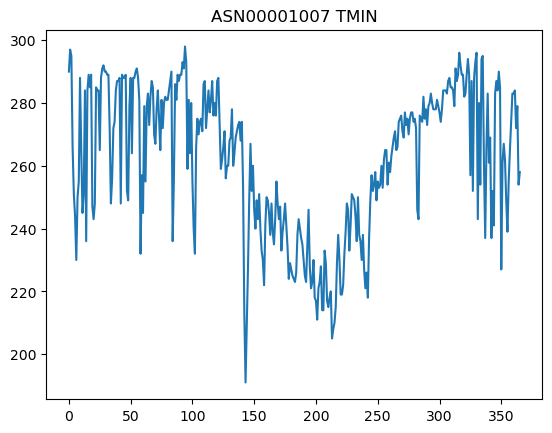

In [38]:
Rows=df.head(100)

R=Rows[11]
figure()
plot(numpy.frombuffer(R[-1],dtype=np.int16))
title(R[0]+' '+R[1]);

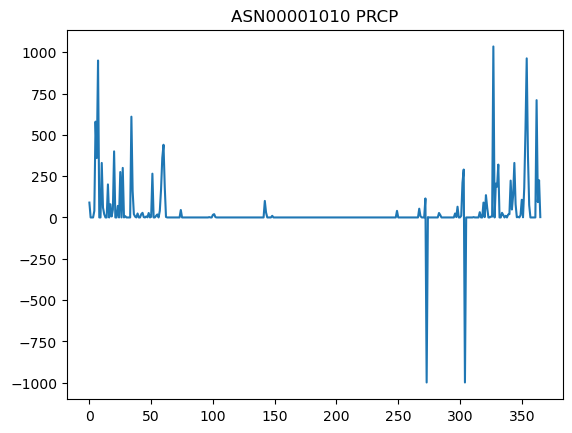

In [39]:
R=Rows[12]
figure()
plot(numpy.frombuffer(R[-1],dtype=np.int16))
title(R[0]+' '+R[1]);

In [40]:
%%time
parquet_filename='../Data/Weather/2020-parquet/'
!rm -rf $parquet_filename
df.write.save(parquet_filename)

CPU times: user 40.8 ms, sys: 29.2 ms, total: 70.1 ms
Wall time: 1min 12s


In [41]:
!ls -l ../Data/Weather/2020-parquet | head

total 82732
-rw-r--r-- 1 jovyan users 1298696 Apr 14 18:40 part-00000-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1241599 Apr 14 18:40 part-00001-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1274180 Apr 14 18:40 part-00002-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1265075 Apr 14 18:40 part-00003-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1327728 Apr 14 18:40 part-00004-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1296653 Apr 14 18:40 part-00005-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1309470 Apr 14 18:40 part-00006-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1322110 Apr 14 18:40 part-00007-c944cf2a-f122-43e1-9ed7-77a8c079bf7c-c000.snappy.parquet
-rw-r--r-- 1 jovyan users 1273340 Apr 14 18:40 part-00008-c944cf2a-f